In [1]:
import numpy as np
import pandas as pd
import logging
import pickle
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
# from imblearn.pipeline import Pipeline as Pipe

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
df.any().isnull()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [5]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
df.Class.value_counts() / len(df)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [7]:
X = df.drop(columns='Class')
y = df.Class

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=0.3,
    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((199364, 30), (85443, 30), (199364,), (85443,))

In [9]:
y_train.value_counts()

0    199008
1       356
Name: Class, dtype: int64

## Using class_weight

In [10]:
def run_Logit(results, X_train, X_test, y_train, y_test, class_weight = None, sample_weight = None):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    # weights introduced here
    logit = LogisticRegression(
        penalty='l2',
        solver='newton-cg',
        random_state=69,
        max_iter=1000,
        n_jobs=-1,
        class_weight=class_weight # weights / cost
    )
    
    logit.fit(X_train, y_train, sample_weight=sample_weight)

    print(f"Class weight:{class_weight}, Sample weight:{sample_weight}")
    print('Train set')
    pred = logit.predict_proba(X_train)
    roc_auc_train = roc_auc_score(y_train, pred[:, 1])
    print(
        'Roc-Auc score: {}'.format(roc_auc_train))

    print('Test set')
    pred = logit.predict_proba(X_test)
    roc_auc_test = roc_auc_score(y_test, pred[:, 1])
    print(
        'Roc-Auc score: {}'.format(roc_auc_test))
    print()
    weight_results.append((class_weight,sample_weight,roc_auc_test,roc_auc_train))

    if sample_weight is None:
        ax_ = plt.axes()
        fig, ax = plt.subplots()
        viz = plot_roc_curve(logit,X_test,y_test,sample_weight,ax=ax_)

        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                label='Chance', alpha=.8)
        tpr = viz.tpr
        tpr[-1] = 1.0
        ax.plot(viz.fpr, viz.tpr, color='b',
                label=r'ROC score (AUC = %0.5f)' % (roc_auc_test),
                lw=2, alpha=.8)
        ax_.remove()
        ax.legend(loc="lower right")
        plt.title(f"ROC Curve - Class weight:{class_weight}, Sample weight:{sample_weight}")
        plt.show()

Class weight:None, Sample weight:None
Train set
Roc-Auc score: 0.9793727732248583
Test set
Roc-Auc score: 0.9783242220657709



C:\Users\kostas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass sample_weight=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


<Figure size 432x288 with 0 Axes>

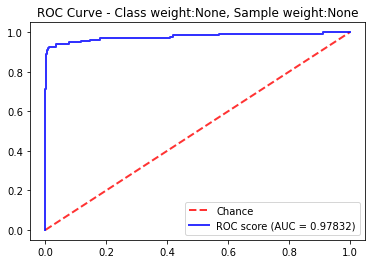

Class weight:balanced, Sample weight:None
Train set
Roc-Auc score: 0.9881987904387786
Test set
Roc-Auc score: 0.9820372388584068



C:\Users\kostas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass sample_weight=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


<Figure size 432x288 with 0 Axes>

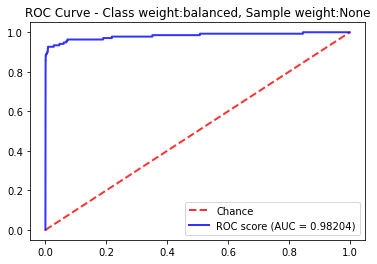

Class weight:{0: 1, 1: 1000}, Sample weight:None
Train set
Roc-Auc score: 0.988895455165486
Test set
Roc-Auc score: 0.9820733109964772



C:\Users\kostas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass sample_weight=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


<Figure size 432x288 with 0 Axes>

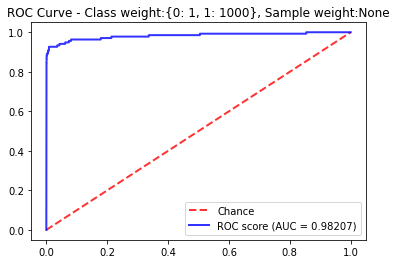

Class weight:None, Sample weight:[1 1 1 ... 1 1 1]
Train set
Roc-Auc score: 0.985417742226161
Test set
Roc-Auc score: 0.9817858113153944

Class weight:balanced, Sample weight:[1 1 1 ... 1 1 1]
Train set
Roc-Auc score: 0.9886132125454614
Test set
Roc-Auc score: 0.9782525087590218



In [11]:
try:
   weight_results = pickle.load( open( "weight_results.p", "rb" ) )
except:
   weight_results = []

   run_Logit(weight_results,
            X_train,
            X_test,
            y_train,
            y_test,
            class_weight=None,
            sample_weight=None)

   run_Logit(weight_results,
            X_train,
            X_test,
            y_train,
            y_test,
            class_weight='balanced',
            sample_weight=None)

   run_Logit(weight_results,
            X_train,
            X_test,
            y_train,
            y_test,
            class_weight={0:1, 1:1000}, #imbalance ratio
            sample_weight=None)

   #Using sample_weight


   run_Logit(weight_results,
            X_train,
            X_test,
            y_train,
            y_test,
            class_weight=None,
            sample_weight=np.where(y_train==1,100,1))

   #Using both
   run_Logit(weight_results,
            X_train,
            X_test,
            y_train,
            y_test,
            class_weight='balanced',
            sample_weight=np.where(y_train==1,100,1))

   pickle.dump( weight_results, open( "weight_results.p", "wb" ) )

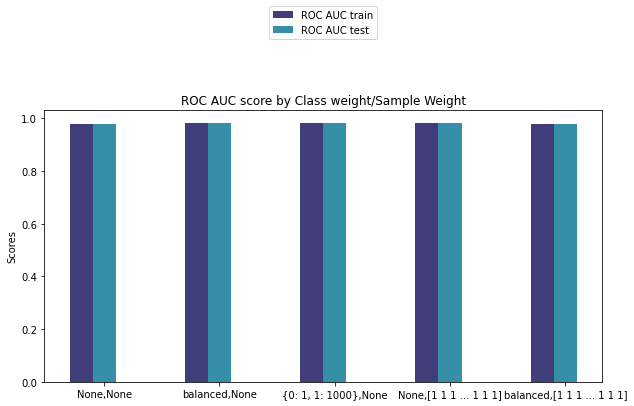

In [12]:
#plot the grouped-barplot
labels = []
roc_auc_train = []
roc_auc_test = []
for i in weight_results:
    labels.append(f"{i[0]},{i[1]}")
for i in weight_results:
    roc_auc_train.append(i[2])
for i in weight_results:
    roc_auc_test.append(i[2])
x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars
palette = itertools.cycle(sns.color_palette("mako"))
fig, ax = plt.subplots(figsize=(10,5))
c = next(palette)
c = next(palette)
rects1 = ax.bar(x - width/3, roc_auc_train, width/3, label='ROC AUC train',color=c)
c = next(palette)
c = next(palette)
rects2 = ax.bar(x, roc_auc_test, width/3, label='ROC AUC test',color=c)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('ROC AUC score by Class weight/Sample Weight')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.4))

plt.show()

## Estimating Cost with Cross Validation

In [13]:
try:
   grid_search = pickle.load( open( "csl_grid.p", "rb" ) )
except:

    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s %(message)s')

    pca = PCA(n_components=13)

    selection = SelectKBest(k=2)

    combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

    X_features = combined_features.fit(X, y).transform(X)
    print("Combined space has", X_features.shape[1], "features")

    pipeline = Pipeline([('scale', StandardScaler()),("features", combined_features), ("clf", RandomForestClassifier(random_state=69))])

    parameters = {
        'clf__n_estimators': [10, 50, 100],
        'clf__max_depth': [2, 3],
        'clf__class_weight': [None, {0:1, 1:10}, {0:1, 1:50}, {0:1, 1:100}, {0:1, 1:400}],
    }
    if __name__ == "__main__":
        grid_search = GridSearchCV(pipeline, parameters,scoring='roc_auc', n_jobs=-1,cv=5,verbose=4)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        t0 = time()
        grid_search.fit(X, y)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best score: %0.3f" % grid_search.best_score_)
        print("Best estimator: ", grid_search.best_estimator_)
        pickle.dump( grid_search, open( "csl_grid.p", "wb" ) )

Combined space has 15 features
Performing grid search...
pipeline: ['scale', 'features', 'clf']
Fitting 5 folds for each of 30 candidates, totalling 150 fits
done in 248.586s

Best score: 0.973
Best estimator:  Pipeline(steps=[('scale', StandardScaler()),
                ('features',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=13)),
                                                ('univ_select',
                                                 SelectKBest(k=2))])),
                ('clf',
                 RandomForestClassifier(class_weight={0: 1, 1: 400},
                                        max_depth=3, random_state=69))])


In [14]:
df_ = pd.DataFrame(grid_search.cv_results_)
df_.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__class_weight,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.389757,0.225104,0.121428,0.014817,None,2,10,"{'clf__class_weight': None, 'clf__max_depth': ...",0.953159,0.936718,0.856599,0.835370,0.875918,0.891553,0.045734,30
1,22.633035,1.087146,0.246531,0.039157,None,2,50,"{'clf__class_weight': None, 'clf__max_depth': ...",0.958129,0.940644,0.915733,0.949893,0.926754,0.938231,0.015334,27
2,37.556395,1.182304,0.440499,0.111598,None,2,100,"{'clf__class_weight': None, 'clf__max_depth': ...",0.965637,0.939739,0.929628,0.937923,0.944454,0.943476,0.012072,24
3,8.069765,1.156798,0.103623,0.018186,None,3,10,"{'clf__class_weight': None, 'clf__max_depth': ...",0.953451,0.935583,0.900128,0.937118,0.894893,0.924235,0.022762,29
4,23.983166,0.485900,0.257058,0.049839,None,3,50,"{'clf__class_weight': None, 'clf__max_depth': ...",0.977794,0.943779,0.920556,0.950661,0.937815,0.946121,0.018718,23


In [15]:
grid_search.best_params_

{'clf__class_weight': {0: 1, 1: 400},
 'clf__max_depth': 3,
 'clf__n_estimators': 100}

In [16]:
try:
   rf_cs = pickle.load( open( "rf_cs.p", "rb" ) )
except:
    rf_cs = RandomForestClassifier(n_estimators=100,
                                random_state=69,
                                max_depth=3,
                                n_jobs=-1,
                                class_weight={0: 1, 1: 400})


    rf_cs.fit(X_train,y_train)
    pickle.dump( rf_cs, open( "rf_cs.p", "wb" ) )
finally:
    rf = RandomForestClassifier(n_estimators=100,
                            random_state=69,
                            max_depth=3,
                            n_jobs=-1,
                            class_weight=None)
    rf.fit(X_train,y_train)

    roc_auc_train_rf = roc_auc_score(y_train,rf.predict_proba(X_train)[:, 1])
    roc_auc_test_rf= roc_auc_score(y_test,rf.predict_proba(X_test)[:, 1])
    roc_auc_train_rfcs = roc_auc_score(y_train,rf_cs.predict_proba(X_train)[:, 1])
    roc_auc_test_rfcs = roc_auc_score(y_test,rf_cs.predict_proba(X_test)[:, 1])
    print(roc_auc_test_rf,roc_auc_test_rfcs)

0.9705358725130481 0.9770429069678441


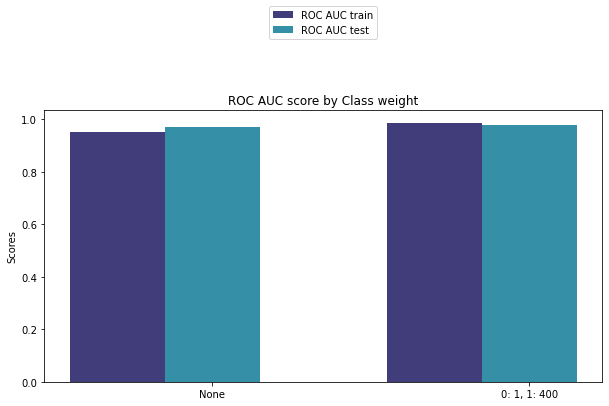

In [17]:
labels = ['None','0: 1, 1: 400']
roc_auc_train = [roc_auc_train_rf,roc_auc_train_rfcs]
roc_auc_test = [roc_auc_test_rf,roc_auc_test_rfcs]

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars
palette = itertools.cycle(sns.color_palette("mako"))
fig, ax = plt.subplots(figsize=(10,5))
c = next(palette)
c = next(palette)
rects1 = ax.bar(x - width/2, roc_auc_train, width/2, label='ROC AUC train',color=c)
c = next(palette)
c = next(palette)
rects2 = ax.bar(x, roc_auc_test, width/2, label='ROC AUC test',color=c)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('ROC AUC score by Class weight')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.4))

plt.show()

## Over/Under Sampling

In [18]:
print("Roc-Auc Scores without Over/Under Sampling")
print(f"Test: {roc_auc_test_rf}, Test: {roc_auc_test_rf}")

Roc-Auc Scores without Over/Under Sampling
Test: 0.9705358725130481, Test: 0.9705358725130481


In [19]:
try:
   rf_os = pickle.load( open( "rf_os.p", "rb" ) )
except:
    over = SMOTE(sampling_strategy=0.1)
    X, y = over.fit_resample(X,y)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state=42)
    rf.fit(X_train,y_train)
    pickle.dump( rf, open( "rf_os.p", "wb" ) )
finally:
    roc_auc_train_rfos = roc_auc_score(y_train,rf_os.predict_proba(X_train)[:, 1])
    roc_auc_test_rfos = roc_auc_score(y_test,rf_os.predict_proba(X_test)[:, 1])
    print("Roc-Auc Scores with Over Sampling")
    print(f"Test: {roc_auc_train_rfos}, Test: {roc_auc_test_rfos}")

Roc-Auc Scores with Over Sampling
Test: 0.9679600495423593, Test: 0.971856147243968


In [20]:
try:
   rf_us = pickle.load( open( "rf_us.p", "rb" ) )
except:
    under = RandomUnderSampler(sampling_strategy=0.5)
    X, y = under.fit_resample(X,y)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state=42)
    rf.fit(X_train,y_train)
    pickle.dump( rf, open( "rf_us.p", "wb" ) )
finally:
    roc_auc_train_rfus = roc_auc_score(y_train,rf_us.predict_proba(X_train)[:, 1])
    roc_auc_test_rfus = roc_auc_score(y_test,rf_us.predict_proba(X_test)[:, 1])
    print("Roc-Auc Scores with Under Sampling")
    print(f"Test: {roc_auc_train_rfus}, Test: {roc_auc_test_rfus}")

Roc-Auc Scores with Under Sampling
Test: 0.9780692783961257, Test: 0.9806783492700069


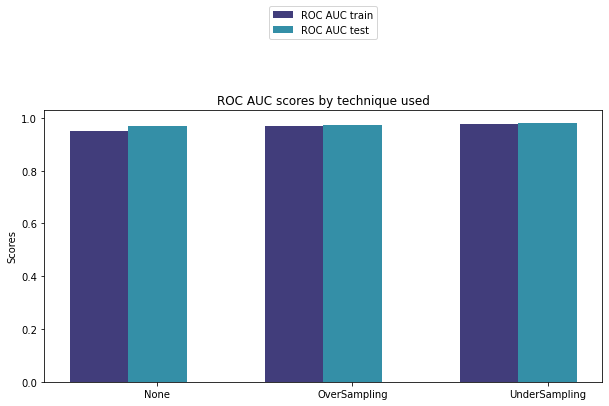

In [21]:
labels = ['None','OverSampling','UnderSampling']
roc_auc_train = [roc_auc_train_rf,roc_auc_train_rfos,roc_auc_train_rfus]
roc_auc_test = [roc_auc_test_rf,roc_auc_test_rfos,roc_auc_test_rfus]

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars
palette = itertools.cycle(sns.color_palette("mako"))
fig, ax = plt.subplots(figsize=(10,5))
c = next(palette)
c = next(palette)
rects1 = ax.bar(x - width/2, roc_auc_train, width/2, label='ROC AUC train',color=c)
c = next(palette)
c = next(palette)
rects2 = ax.bar(x, roc_auc_test, width/2, label='ROC AUC test',color=c)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('ROC AUC scores by technique used')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.4))

plt.show()

## MetaCost

In [22]:
from metacost import MetaCost

In [23]:
cost_matrix = np.array([[0, 1], [1, 0]])
cost_matrix2 = np.array([[0, 400], [1, 0]])

In [24]:
logreg = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    random_state=69,
    max_iter=1000,
    n_jobs=-1,
)

In [25]:
metacost_ = MetaCost(estimator=logreg,
                     cost_matrix=cost_matrix,
                     n_estimators=50,
                     n_samples=None,
                     p=True,
                     q=True)
metacost2 = MetaCost(estimator=logreg,
                     cost_matrix=cost_matrix2,
                     n_estimators=50,
                     n_samples=None,
                     p=True,
                     q=True)                                     

In [26]:
try:
   metacost_ = pickle.load( open( "meta_1.p", "rb" ) )
except:
    metacost_.fit(X_train, y_train)
    pickle.dump( metacost_, open( "meta_1.p", "wb" ) )

In [27]:
print('MetaCost without Costs')
print('Train set')
pred = metacost_.predict_proba(X_train)
roc_auc_train_nm = roc_auc_score(y_train, pred[:, 1])
print(
    'MetaCost roc-auc: {}'.format(roc_auc_train_nm))

print('Test set')
pred = metacost_.predict_proba(X_test)
roc_auc_test_nm = roc_auc_score(y_test, pred[:, 1])
print(
    'MetaCost roc-auc: {}'.format(roc_auc_test_nm))

MetaCost without Costs
Train set
MetaCost roc-auc: 0.9800222869477553
Test set
MetaCost roc-auc: 0.978562289557646


In [28]:
try:
   metacost2 = pickle.load( open( "meta_2.p", "rb" ) )
except:
    metacost2.fit(X_train, y_train)
    pickle.dump( metacost2, open( "meta_2.p", "wb" ) )

In [29]:
print('MetaCost with Costs')
print('Train set')
pred = metacost2.predict_proba(X_train)
roc_auc_train_mc = roc_auc_score(y_train, pred[:, 1])
print(
    'MetaCost roc-auc: {}'.format(roc_auc_train_mc))

print('Test set')
pred = metacost2.predict_proba(X_test)
roc_auc_test_mc = roc_auc_score(y_test, pred[:, 1])
print(
    'MetaCost roc-auc: {}'.format(roc_auc_test_mc))

MetaCost with Costs
Train set
MetaCost roc-auc: 0.9796647904505222
Test set
MetaCost roc-auc: 0.9815939006453509


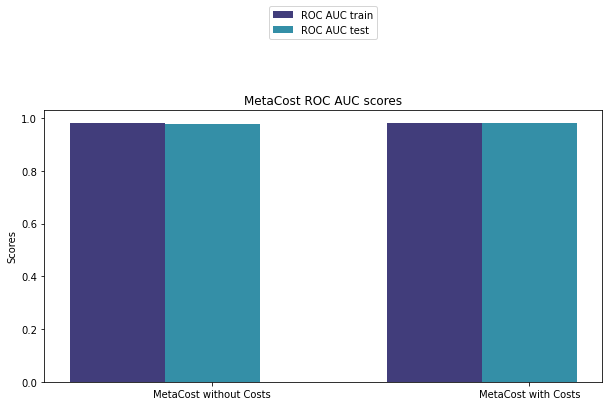

In [30]:
labels = ['MetaCost without Costs','MetaCost with Costs']
roc_auc_train = [roc_auc_train_nm,roc_auc_train_mc]
roc_auc_test = [roc_auc_test_nm,roc_auc_test_mc]

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars
palette = itertools.cycle(sns.color_palette("mako"))
fig, ax = plt.subplots(figsize=(10,5))
c = next(palette)
c = next(palette)
rects1 = ax.bar(x - width/2, roc_auc_train, width/2, label='ROC AUC train',color=c)
c = next(palette)
c = next(palette)
rects2 = ax.bar(x, roc_auc_test, width/2, label='ROC AUC test',color=c)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('MetaCost ROC AUC scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.4))

plt.show()

In [31]:
y_train.reset_index(drop=True)

0         0
1         0
2         0
3         0
4         0
         ..
199359    0
199360    0
199361    0
199362    0
199363    0
Name: Class, Length: 199364, dtype: int64

In [32]:
tmp = pd.concat([metacost2.y_, y_train.reset_index(drop=True)], axis=1)

tmp.head()

,0,Class
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [33]:
tmp[tmp[0]!=tmp['Class']][['Class', 0]]

,Class,0
6,0,1
17,0,1
49,0,1
73,0,1
76,0,1
...,...,...
199148,0,1
199209,0,1
199315,0,1
199317,0,1


In [34]:
np.sum( np.where(metacost2.y_ != y_train.reset_index(drop=True),1,0) )

5355

In [35]:
np.sum( np.where(metacost2.y_ == y_train.reset_index(drop=True),1,0) )

194009